In [3]:
# Imports Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score,precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV

In [4]:
# Load Data
log = pd.read_csv(r"C:\Users\Nihar Patel\Projects\Classifiaction\Log Data.csv")
prod_cost = pd.read_csv(r"C:\Users\Nihar Patel\Projects\Classifiaction\Production Costs.csv")
products = pd.read_csv(r"C:\Users\Nihar Patel\Projects\Classifiaction\Products.csv")
shipping = pd.read_csv(r"C:\Users\Nihar Patel\Projects\Classifiaction\Warehouse Shipping Costs.csv")

In [5]:
# Merge Data
df = log.merge(prod_cost, on="Product_ID", how="left")
df = df.merge(products, on="Product_ID", how="left")
df = df.merge(shipping, on=["Warehouse_ID", "Source_Factory_ID"], how="left")
df.head(3)

,Date,Order_ID,Product_ID_x,Warehouse_ID,Source_Factory_ID,Shipping_Time(Expected),Shipping_Time(Actual),Delay_Risk?,Total_Pieces,Pieces_sold,Pieces_Returned,Avg_Batch_Rating,Factory_ID,Manufacturing_Cost,Name,Gender,Selling_Price,Weight(in Kg),Product_ID_y,Shipping_Cost(per 1000 pieces)
0,01-04-2023,O00001,P011,W013,F001,4,4,No,1873,1368,76,4.4,F001,16.036461,Men's Blazer,M,80,2.2,P006,7200
1,01-04-2023,O00001,P011,W013,F001,4,4,No,1873,1368,76,4.4,F001,16.036461,Men's Blazer,M,80,2.2,P008,4000
2,01-04-2023,O00001,P011,W013,F001,4,4,No,1873,1368,76,4.4,F001,16.036461,Men's Blazer,M,80,2.2,P011,17600


In [6]:
# Clean Data
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [7]:
# Create Target Column
df["Delay_Risk?"] = np.where(df["Shipping_Time(Actual)"] > df["Shipping_Time(Expected)"], 1, 0)

In [8]:
# Drop Leakage and Useless Columns
df.drop(["Date", "Order_ID", "Product_ID_x", "Product_ID_y","Shipping_Time(Actual)", "Name","Gender"], axis=1, inplace=True)

In [9]:
# Shifting target column to the last
delay_col = df.pop("Delay_Risk?")
df["Delay_Risk?"] = delay_col

In [10]:
# Encode Categorical Columns
le = LabelEncoder()
for col in df.select_dtypes(include="object").columns:
    df[col] = le.fit_transform(df[col])

df

,Warehouse_ID,Source_Factory_ID,Shipping_Time(Expected),Total_Pieces,Pieces_sold,Pieces_Returned,Avg_Batch_Rating,Factory_ID,Manufacturing_Cost,Selling_Price,Weight(in Kg),Shipping_Cost(per 1000 pieces),Delay_Risk?
0,12,0,4,1873,1368,76,4.4,0,16.036461,80,2.20,7200,0
1,12,0,4,1873,1368,76,4.4,0,16.036461,80,2.20,4000,0
2,12,0,4,1873,1368,76,4.4,0,16.036461,80,2.20,17600,0
3,12,0,4,1873,1368,76,4.4,0,16.036461,80,2.20,1600,0
4,12,0,4,1873,1368,76,4.4,0,16.036461,80,2.20,1600,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1788418,18,1,6,1522,1311,40,4.7,4,10.936400,15,0.05,1600,1
1788419,18,1,6,1522,1311,40,4.7,4,10.936400,15,0.05,4800,1
1788420,18,1,6,1522,1311,40,4.7,4,10.936400,15,0.05,400,1
1788421,18,1,6,1522,1311,40,4.7,4,10.936400,15,0.05,4800,1


In [11]:
# Split Features and Target
x = df.iloc[:,:-1]
y = df["Delay_Risk?"]

In [12]:
y.value_counts()

Delay_Risk?
0    1145585
1     642838
Name: count, dtype: int64

In [13]:
# Handle Imbalance with RandomOverSampler
ros = RandomOverSampler(random_state=42)
x_ro, y_ro = ros.fit_resample(x,y)
y_ro.value_counts()

Delay_Risk?
0    1145585
1    1145585
Name: count, dtype: int64

In [14]:
# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(x_ro,y_ro, test_size=0.2, random_state=42)

In [15]:
# Train Decision Tree
dt = DecisionTreeClassifier(class_weight="balanced", random_state=42)
dt.fit(x_train,y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [16]:
# Model Accuracy
dt.score(x_test,y_test)*100

99.99607187594111

In [17]:
# Predict and Evaluate
y_pred = dt.predict(x_test)

In [19]:
cf = confusion_matrix(y_test, y_pred)

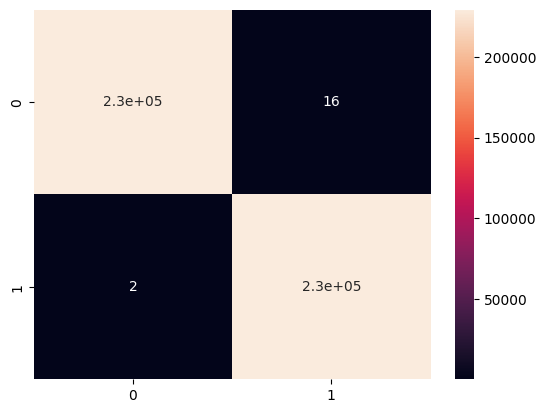

F1 Score : 99.99607793577403
Precision : 99.99302765406706
Recall : 99.99912840358401


In [20]:
# Results
sns.heatmap(cf, annot=True)
plt.show()
f1 = f1_score(y_test, y_pred)*100
precision = precision_score(y_test,y_pred)*100
recall = recall_score(y_test,y_pred)*100
print("F1 Score :",f1)
print("Precision :",precision)
print("Recall :",recall)

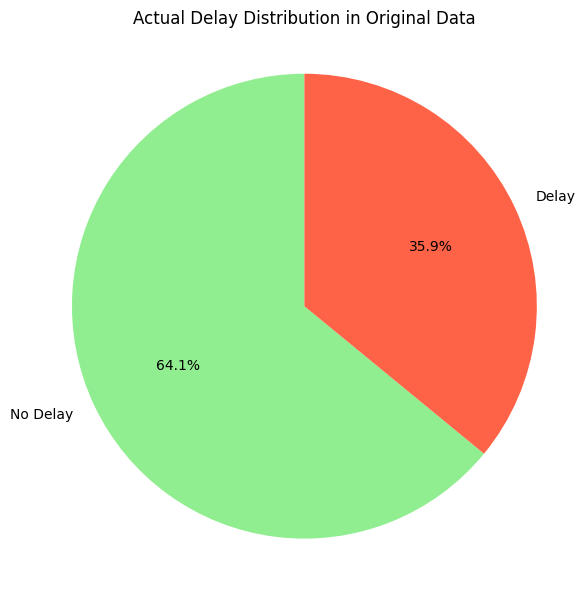

In [21]:
# Convert y_test to Series if it's not already
y_test_series = pd.Series(y, name="Actual Delay Risk")

# Count actual delay (1) and no delay (0)
actual_counts = y_test_series.value_counts().sort_index()  # 0 = No Delay, 1 = Delay

# Labels for the pie chart
labels = ['No Delay', 'Delay']

# Plot
plt.figure(figsize=(6,6))
plt.pie(actual_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'tomato'])
plt.title("Actual Delay Distribution in Original Data")
plt.axis("equal")  # Make the pie circular
plt.tight_layout()
plt.show()

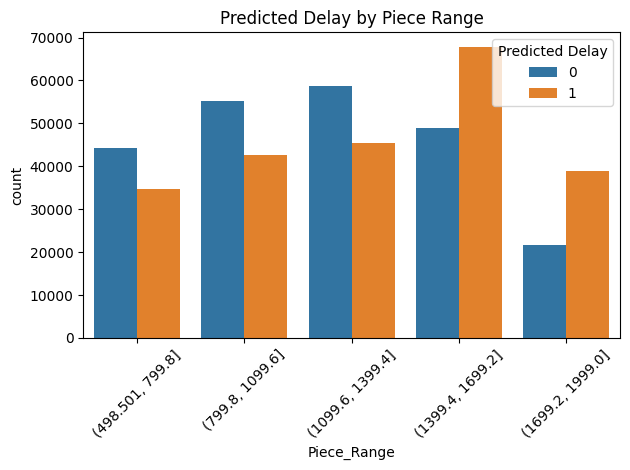

In [22]:
# Add predictions back to X_test
x_test_copy = x_test.copy()
x_test_copy['Predicted'] = y_pred

# Bin one feature (e.g., Total_Pieces)
x_test_copy['Piece_Range'] = pd.cut(x_test_copy['Total_Pieces'], bins=5)

# Barplot
sns.countplot(data=x_test_copy, x='Piece_Range', hue='Predicted')
plt.title("Predicted Delay by Piece Range")
plt.xticks(rotation=45)
plt.legend(title="Predicted Delay")
plt.tight_layout()
plt.show()
